#################################
# Appendix

## (1)  Evaluating CATE predictions

> Ok, we have a CATE model and its predictions. But how good is it?
> * We can't compare actual and predicted values since actual treatment effect is unobserved at a unit level.
> * Let's use a traditional train/test split and cross-validation for evaluation.

#### Load data again

In [ ]:
df = pd.read_csv('data.csv')

df['day'] = pd.to_datetime(df['day'])
df['weekday'] = df['day'].dt.weekday

#### Before we start, let's first learn about @curry:

In [ ]:
from toolz import curry

In [ ]:
# Curry
@curry
def addN(x, N):
    return x + N

ad5 = addN(N=5)
ad13 = addN(N=13)

print(ad5(5))
print(ad13(5))

10
18


#### Defince a function to get the ATE

In [ ]:
@curry
def effect(data, y, t):
    return smf.ols(f"{y} ~ {t}", data=data).fit(cov_type='HC2').params[1]

In [ ]:
# Example
effect(df, "kpi", "treated")

10.377897351139008

### Use a simple train/test-split for cross-validation

In [ ]:
# Let's make use of the time dimension and define test set to be the last month of the data
train = df.query("day<'2024-01-21'")
test = df.query("day>='2024-01-21'")

In [ ]:
# Define feature set and learn the model on the training data
X = ["C(weekday)", "ch1", "ch2"]
regr_model = smf.ols(f"kpi ~ treated*({'+'.join(X)})", data=train).fit(cov_type='HC2')

In [ ]:
# Get the predicted values on the test set
cate_pred = (
    regr_model.predict(test.assign(treated=test["treated"]+1))
    - regr_model.predict(test)
)

In [ ]:
# Benchmark with purely predictive ML model
from sklearn.ensemble import GradientBoostingRegressor

X = ["weekday", "ch1", "ch2", "treated"]
y = "kpi"

np.random.seed(42)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X], train[y])

ml_pred = ml_model.predict(test[X])

In [ ]:
# Store everything in a dataframe
test_pred = test.assign(
    gradboos_kpi_pred=ml_pred,
    cate_pred=cate_pred,
    rand_m_pred=np.random.uniform(-1,1,len(test))
)

In [ ]:
test_pred.head()

,user_id,day,ch1,ch2,treated,kpi,weekday,gradboos_kpi_pred,cate_pred,rand_m_pred
65,0,2024-01-21,5,4,0,72,6,60.525583,10.096486,0.570352
66,0,2024-01-22,45,4,0,39,0,43.600034,3.773010,-0.600652
67,0,2024-01-23,98,4,0,0,1,0.121331,18.624116,0.028469
68,0,2024-01-24,12,4,0,57,2,62.174531,-4.785771,0.184829
69,0,2024-01-25,11,4,0,59,3,62.174531,-4.645760,-0.907099


In [ ]:
# Get effect by quantiles
def effect_by_quantile(data,pred, y, t, q=10):

    # makes quantile partitions
    groups = np.round(pd.IntervalIndex(pd.qcut(data[pred], q=q)).mid, 2)

    result = pd.DataFrame(data.assign(**{f"{pred}_quantile": groups})
              .groupby(f"{pred}_quantile")
              # estimate effect in each quantile
              .apply(effect, y=y, t=t), columns = ["cate_pred"])

    return result

In [ ]:
effect_by_quantile(test_pred, "cate_pred", y = "kpi", t = "treated")

,cate_pred
cate_pred_quantile,
-6.33,-4.722041
-2.34,-4.366625
1.40,-0.702253
5.16,3.927728
8.63,11.620752
11.58,16.296635
14.29,17.380961
16.95,13.654991
22.15,19.549823


> The out-of-sample CATE prediction approximates the "true" underlying CATE pretty well.

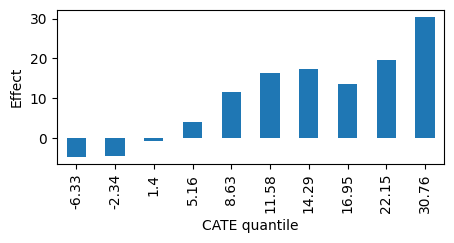

In [ ]:
# Plot the "true" CATE by predicted CATE quantiles from CATE model
plt.figure(figsize=(5,2))
effect_by_quantile(test_pred, "cate_pred", y = "kpi", t = "treated").plot(kind='bar')
plt.xlabel('CATE quantile')
plt.ylabel('Effect')
plt.show()


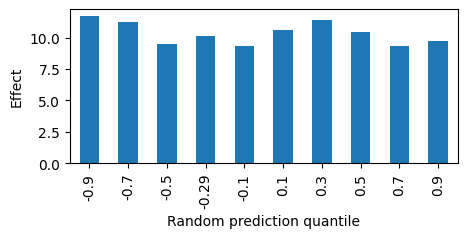

In [ ]:
# Plot the "true" CATE by predicted CATE quantiles from random benchmark model
plt.figure(figsize=(5,2))
effect_by_quantile(test_pred, "rand_m_pred", y = "kpi", t = "treated").plot(kind='bar')
plt.xlabel('Random prediction quantile')
plt.ylabel('Effect')
plt.show()

> Random CATE prediction has same estimated effect in all partitions. It won't help with personalisation.

<Figure size 500x200 with 0 Axes>

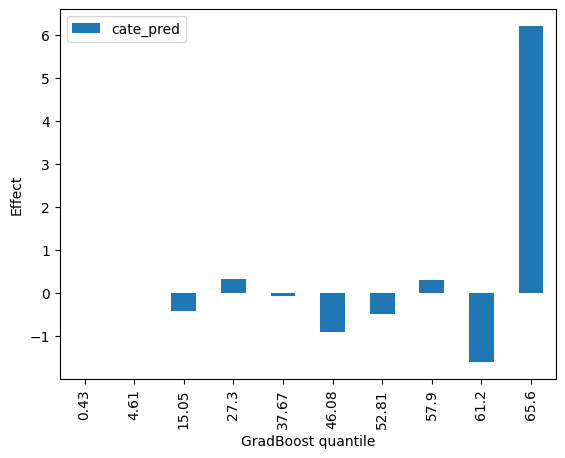

In [ ]:
# Plot the effect by quantiles with a bar chart
plt.figure(figsize=(5,2))
effect_by_quantile(test_pred, "gradboos_kpi_pred", y = "kpi", t = "treated").plot(kind='bar')
plt.xlabel('GradBoost quantile')
plt.ylabel('Effect')
plt.show()

> Looks like group with highest KPI probability also benefits most from intervention.\
> But ordering does not work.\
> In fact, ML can have a lower area under the curve (AUC) in the cumulative Gain Curve than the random model!